# Distance au poste source le plus proche 

In [1]:
from data import ELECTRICAL_SUBSTATIONS, CLEAN_SOLD_HOUSE_PRICES
import pandas as pd
import geojson
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial import distance
from math import radians
import numpy as np
from tqdm import tqdm

In [2]:
with open(ELECTRICAL_SUBSTATIONS, "r") as f:
    substations = geojson.load(f)

sellprices_df = pd.read_csv(CLEAN_SOLD_HOUSE_PRICES)

/tmp/ipykernel_33777/2812814977.py:4: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  sellprices_df = pd.read_csv(SOLD_HOUSE_PRICES)


In [3]:
def get_coordinates(geo_object):
    properties = geo_object["properties"]
    lat = properties["geo_point_2d"]["lat"]
    lon = properties["geo_point_2d"]["lon"]
    departement = properties["nom_departement"]
    
    return [lat, lon], departement

substation_coordinates = [get_coordinates(substation)[0] for substation in substations["features"]]
substation_departements =  [get_coordinates(substation)[1] for substation in substations["features"]]

In [4]:
def get_distance_km(points_a, points_b):
    result = haversine_distances(X=np.radians(points_a), Y=np.radians(points_b))
    # multiply by Earth radius to get kilometers
    return result * 6371000/1000

In [5]:
soldhouse_prices_array = sellprices_df[["latitude", "longitude"]].to_numpy()

In [6]:
chunk_size = 1500
last_chunk_size = soldhouse_prices_array.shape[0] % chunk_size
last_chunk = soldhouse_prices_array[-last_chunk_size:,:]
chunks = soldhouse_prices_array[:-last_chunk_size,:].reshape(-1, chunk_size, soldhouse_prices_array.shape[1])

In [8]:
min_distances = []
min_substation_indices = []
for chunk in tqdm(chunks):
    distance_matrix = get_distance_km(chunk, substation_coordinates)
    distances = np.min(distance_matrix, axis=1)
    source_indices = np.argmin(distance_matrix, axis=1)

    min_substation_indices += source_indices.tolist()
    min_distances += distances.tolist()

distance_matrix = get_distance_km(last_chunk, substation_coordinates)
distances = np.min(distance_matrix, axis=1)
source_indices = np.argmin(distance_matrix, axis=1)

min_substation_indices += source_indices.tolist()
min_distances += distances.tolist()

100%|██████████| 2485/2485 [08:14<00:00,  5.03it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

In [28]:
coordinates = []

sellprices_df["substation_distance"] = min_distances
sellprices_df["substation_index"] = min_substation_indices

min_distances = np.array(min_distances)
min_substation_indices = np.array(min_substation_indices)

sellprices_df["substation_latitude"] = sellprices_df["substation_index"].apply(lambda x: substation_coordinates[x][0])
sellprices_df["substation_longitude"] = sellprices_df["substation_index"].apply(lambda x: substation_coordinates[x][1])
sellprices_df["substation_dapartement"] = sellprices_df["substation_index"].apply(lambda x: substation_departements[x])

sellprices_df["m2_price"] = sellprices_df["valeur_fonciere"] / sellprices_df["surface_reelle_bati"]

In [29]:
selected_houses = sellprices_df.copy()

selected_houses = selected_houses[selected_houses["substation_distance"] <= 0.1]
selected_houses = selected_houses[selected_houses["m2_price"] <= 5000.0]
selected_houses = selected_houses[selected_houses["surface_terrain"] >= 500.0]

selected_houses

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_terrain,longitude,latitude,substation_distance,substation_index,substation_latitude,substation_longitude,substation_dapartement,substation_distance_check,m2_price
7,2022-239,2022-01-13,1,Vente,1000000.0,237.0,NaN,RUE DES TREIZE VENTS,0136,1340.0,...,3688.0,5.118070,46.332307,0.191671,875,46.332895,5.120417,Ain,0.191671,476.190476
19,2022-1068,2022-01-13,1,Vente,279000.0,621.0,NaN,RTE DES ETROUBLES,0135,1340.0,...,500.0,5.133871,46.327891,0.269399,1011,46.328798,5.137124,Ain,0.269399,2607.476636
21,2022-1068,2022-01-13,1,Vente,279000.0,621.0,NaN,RTE DES ETROUBLES,0135,1340.0,...,736.0,5.133871,46.327891,0.269399,1011,46.328798,5.137124,Ain,0.269399,2607.476636
22,2022-1222,2022-01-31,1,Vente,278800.0,897.0,NaN,AV DES HELVETES,0190,1600.0,...,721.0,4.745772,45.950411,0.208765,2408,45.951403,4.748064,Ain,0.208765,3872.222222
24,2022-1292,2022-02-09,1,Vente,170000.0,670.0,NaN,RUE DE LA CASCADE,0010,1300.0,...,1960.0,5.612746,45.665275,0.038716,307,45.664951,5.612930,Ain,0.038716,765.765766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33794,2022-1338676,2022-11-21,1,Vente,615000.0,40.0,NaN,RUE SAINT CLAUDE,0160,95590.0,...,26593.0,2.284527,49.087536,0.253775,1423,49.089805,2.284904,Val-d'Oise,0.253775,2887.323944
33798,2022-1339554,2022-12-21,1,Vente,2400000.0,1.0,B,RUE LAVOISIER,0812,95220.0,...,3367.0,2.170159,49.004427,0.212383,556,49.004432,2.173071,Val-d'Oise,0.212383,1488.833747
36811,2022-1359153,2022-04-12,1,Vente,7800000.0,8.0,NaN,RUE PETRELLE,7359,75009.0,...,1032.0,2.348723,48.880938,0.220965,2508,48.880890,2.345702,Paris,0.220965,4326.123128
38559,2022-1363305,2022-06-27,1,Vente,14500000.0,9.0,NaN,RUE DU RETRAIT,8172,75020.0,...,2128.0,2.395045,48.867911,0.292745,1553,48.868133,2.399033,Paris,0.292745,4651.908887


<Axes: ylabel='Frequency'>

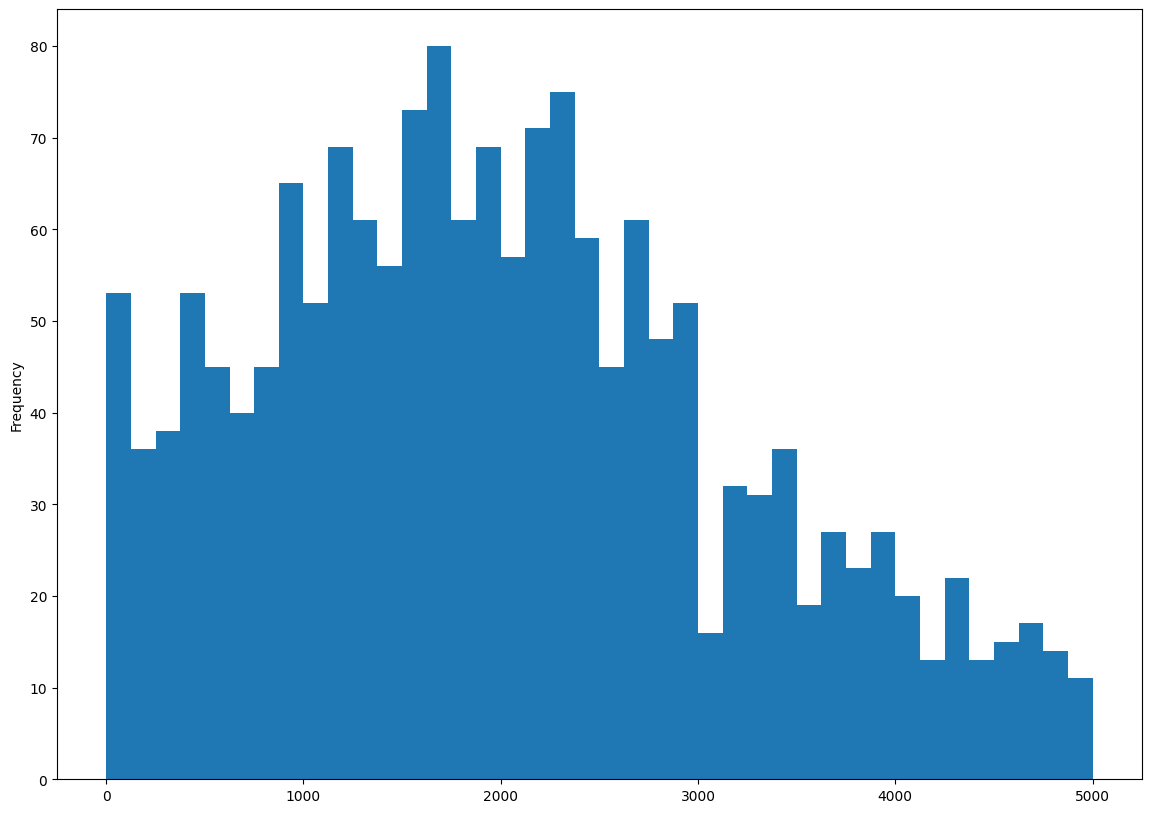

In [30]:
selected_houses["m2_price"].plot.hist(figsize=(14,10), bins=40)

In [31]:
selected_houses.reset_index(drop=True).to_csv("../data/select_houses.csv")